## King County Housing Project
* Student name: Deanna Gould
* Flex Student
* Instructor name: Morgan Jones
* Blog post URL:

## Introduction


The purpose of this project is to create a multiple linear regression model that can accurately predict the sale price of houses in King County, Washington, where Seattle is the largest city. The contributing dataset for this model can be found *here*. 

## Business Problem

A real estate investment firm is considering investing in real estate in King County, and they want to understand the value of homes based on their features, so they know which would be best to invest in and renovate for the best sale price possible. To do that, this notebook will: 

* Find the most highly correlated features to price
* Find any independent features that are too highly correlated to each other (multicollinearity)
* Create a reproducable regression model that best predicts housing prices

Below are the provided fields and their definitions, which we will only use some of:

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

* Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/).

The first few steps will be understanding the data, cleaning the data, checking for multicollinearity, and iterating through models to get the most significant P-values and the best R^2 values, which will produce the most accurate model. The performance of the model can be measured by the Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), R-squared, and Adjusted R-squared. I'll then make recommendations to the stakeholder based on what features I find most important to increasing home prices, or which homes are the best investment. 

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import datasets, linear_model
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [2]:
# Creating the DataFrame for the KC Housing Data

df = pd.read_csv('data/kc_house_data.csv', index_col=0)

In [3]:
# Looking at what the first few rows and columns of the housing data looks like

df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
id,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


In [4]:
# Checking the size of the DataFrame

df.shape

(30155, 24)

In [5]:
# Checking the datatypes in the DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30155 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30155 non-null  object 
 1   price          30155 non-null  float64
 2   bedrooms       30155 non-null  int64  
 3   bathrooms      30155 non-null  float64
 4   sqft_living    30155 non-null  int64  
 5   sqft_lot       30155 non-null  int64  
 6   floors         30155 non-null  float64
 7   waterfront     30155 non-null  object 
 8   greenbelt      30155 non-null  object 
 9   nuisance       30155 non-null  object 
 10  view           30155 non-null  object 
 11  condition      30155 non-null  object 
 12  grade          30155 non-null  object 
 13  heat_source    30123 non-null  object 
 14  sewer_system   30141 non-null  object 
 15  sqft_above     30155 non-null  int64  
 16  sqft_basement  30155 non-null  int64  
 17  sqft_garage    30155 non-null  int64

In [6]:
# Checking which columns may contain null values

df.isna().any()

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
greenbelt        False
nuisance         False
view             False
condition        False
grade            False
heat_source       True
sewer_system      True
sqft_above       False
sqft_basement    False
sqft_garage      False
sqft_patio       False
yr_built         False
yr_renovated     False
address          False
lat              False
long             False
dtype: bool

The heat_source and sewer_system columns have some null values, and I'm not sure how necessary that will be in my analysis, but regardless of that, I'm going to check how many null values are in the column before I remove rows with null values.

In [7]:
# Getting a sum of the null values in each column

df.isna().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

In [8]:
# Creating a copy of the DataFrame so I can compare to the original df I imported without restarting the notebook

kc = df.copy()

In [9]:
# Finding the datatypes of the columns and starting to think about numerical vs categorical columns

kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30155 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30155 non-null  object 
 1   price          30155 non-null  float64
 2   bedrooms       30155 non-null  int64  
 3   bathrooms      30155 non-null  float64
 4   sqft_living    30155 non-null  int64  
 5   sqft_lot       30155 non-null  int64  
 6   floors         30155 non-null  float64
 7   waterfront     30155 non-null  object 
 8   greenbelt      30155 non-null  object 
 9   nuisance       30155 non-null  object 
 10  view           30155 non-null  object 
 11  condition      30155 non-null  object 
 12  grade          30155 non-null  object 
 13  heat_source    30123 non-null  object 
 14  sewer_system   30141 non-null  object 
 15  sqft_above     30155 non-null  int64  
 16  sqft_basement  30155 non-null  int64  
 17  sqft_garage    30155 non-null  int64

In [10]:
# Looking at the number of unique values in each field

kc.nunique()

date               365
price             5202
bedrooms            13
bathrooms           21
sqft_living       1318
sqft_lot         12237
floors               7
waterfront           2
greenbelt            2
nuisance             2
view                 5
condition            5
grade               13
heat_source          7
sewer_system         4
sqft_above        1187
sqft_basement      459
sqft_garage        412
sqft_patio         526
yr_built           123
yr_renovated        83
address          29560
lat              24354
long             24084
dtype: int64

### Some Data Exploration

As seen above, there is still a right skew, but it is a more normal distribution.

In [11]:
# Finding the shape of the dataframe to see how many rows and columns there are

kc.shape

(30155, 24)

In [12]:
# Checking again how many null values there are in each column of the kc DataFrame

kc.isna().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

In [13]:
# Dropping null values

kc.dropna(inplace=True)

In [14]:
# Double checking that the null values were dropped

kc.isna().any()

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
greenbelt        False
nuisance         False
view             False
condition        False
grade            False
heat_source      False
sewer_system     False
sqft_above       False
sqft_basement    False
sqft_garage      False
sqft_patio       False
yr_built         False
yr_renovated     False
address          False
lat              False
long             False
dtype: bool

Great! All of the null values have been dropped. Now I'm going to create a DataFrame for the numeric independent variables.

In [15]:
# Creating a DataFrame for independent variables based on correlation and their absolute values

X_corr = kc.corr().abs()
X_corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
price,1.000000,0.288954,0.480337,0.608616,0.086550,0.180589,0.538631,0.245005,0.263674,0.313789,0.095796,0.085023,0.063430,0.022278
bedrooms,0.288954,1.000000,0.588035,0.637048,0.006215,0.146871,0.546221,0.237957,0.318110,0.183660,0.145497,0.015369,0.108883,0.106791
bathrooms,0.480337,0.588035,1.000000,0.772226,0.038028,0.404291,0.674239,0.260684,0.456264,0.327982,0.443379,0.041574,0.005481,0.017684
sqft_living,0.608616,0.637048,0.772226,1.000000,0.122271,0.303911,0.883733,0.338387,0.510967,0.396530,0.291242,0.039089,0.102205,0.087625
sqft_lot,0.086550,0.006215,0.038028,0.122271,1.000000,0.031555,0.131756,0.004457,0.089318,0.154575,0.001897,0.009390,0.030041,0.034408
floors,0.180589,0.146871,0.404291,0.303911,0.031555,1.000000,0.448245,0.248466,0.132363,0.125016,0.544314,0.025041,0.218174,0.233589
sqft_above,0.538631,0.546221,0.674239,0.883733,0.131756,0.448245,1.000000,0.067306,0.559972,0.312593,0.387253,0.011036,0.092317,0.082722
sqft_basement,0.245005,0.237957,0.260684,0.338387,0.004457,0.248466,0.067306,1.000000,0.025766,0.210305,0.230783,0.054032,0.059664,0.045104
sqft_garage,0.263674,0.318110,0.456264,0.510967,0.089318,0.132363,0.559972,0.025766,1.000000,0.216512,0.447720,0.098301,0.092092,0.096639
sqft_patio,0.313789,0.183660,0.327982,0.396530,0.154575,0.125016,0.312593,0.210305,0.216512,1.000000,0.138112,0.056183,0.019666,0.025675


In [16]:
# Returning True or False if there's a correlation above 0.3

X_corr > 0.3

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
price,True,False,True,True,False,False,True,False,False,True,False,False,False,False
bedrooms,False,True,True,True,False,False,True,False,True,False,False,False,False,False
bathrooms,True,True,True,True,False,True,True,False,True,True,True,False,False,False
sqft_living,True,True,True,True,False,True,True,True,True,True,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False
floors,False,False,True,True,False,True,True,False,False,False,True,False,False,False
sqft_above,True,True,True,True,False,True,True,False,True,True,True,False,False,False
sqft_basement,False,False,False,True,False,False,False,True,False,False,False,False,False,False
sqft_garage,False,True,True,True,False,False,True,False,True,False,True,False,False,False
sqft_patio,True,False,True,True,False,False,True,False,False,True,False,False,False,False


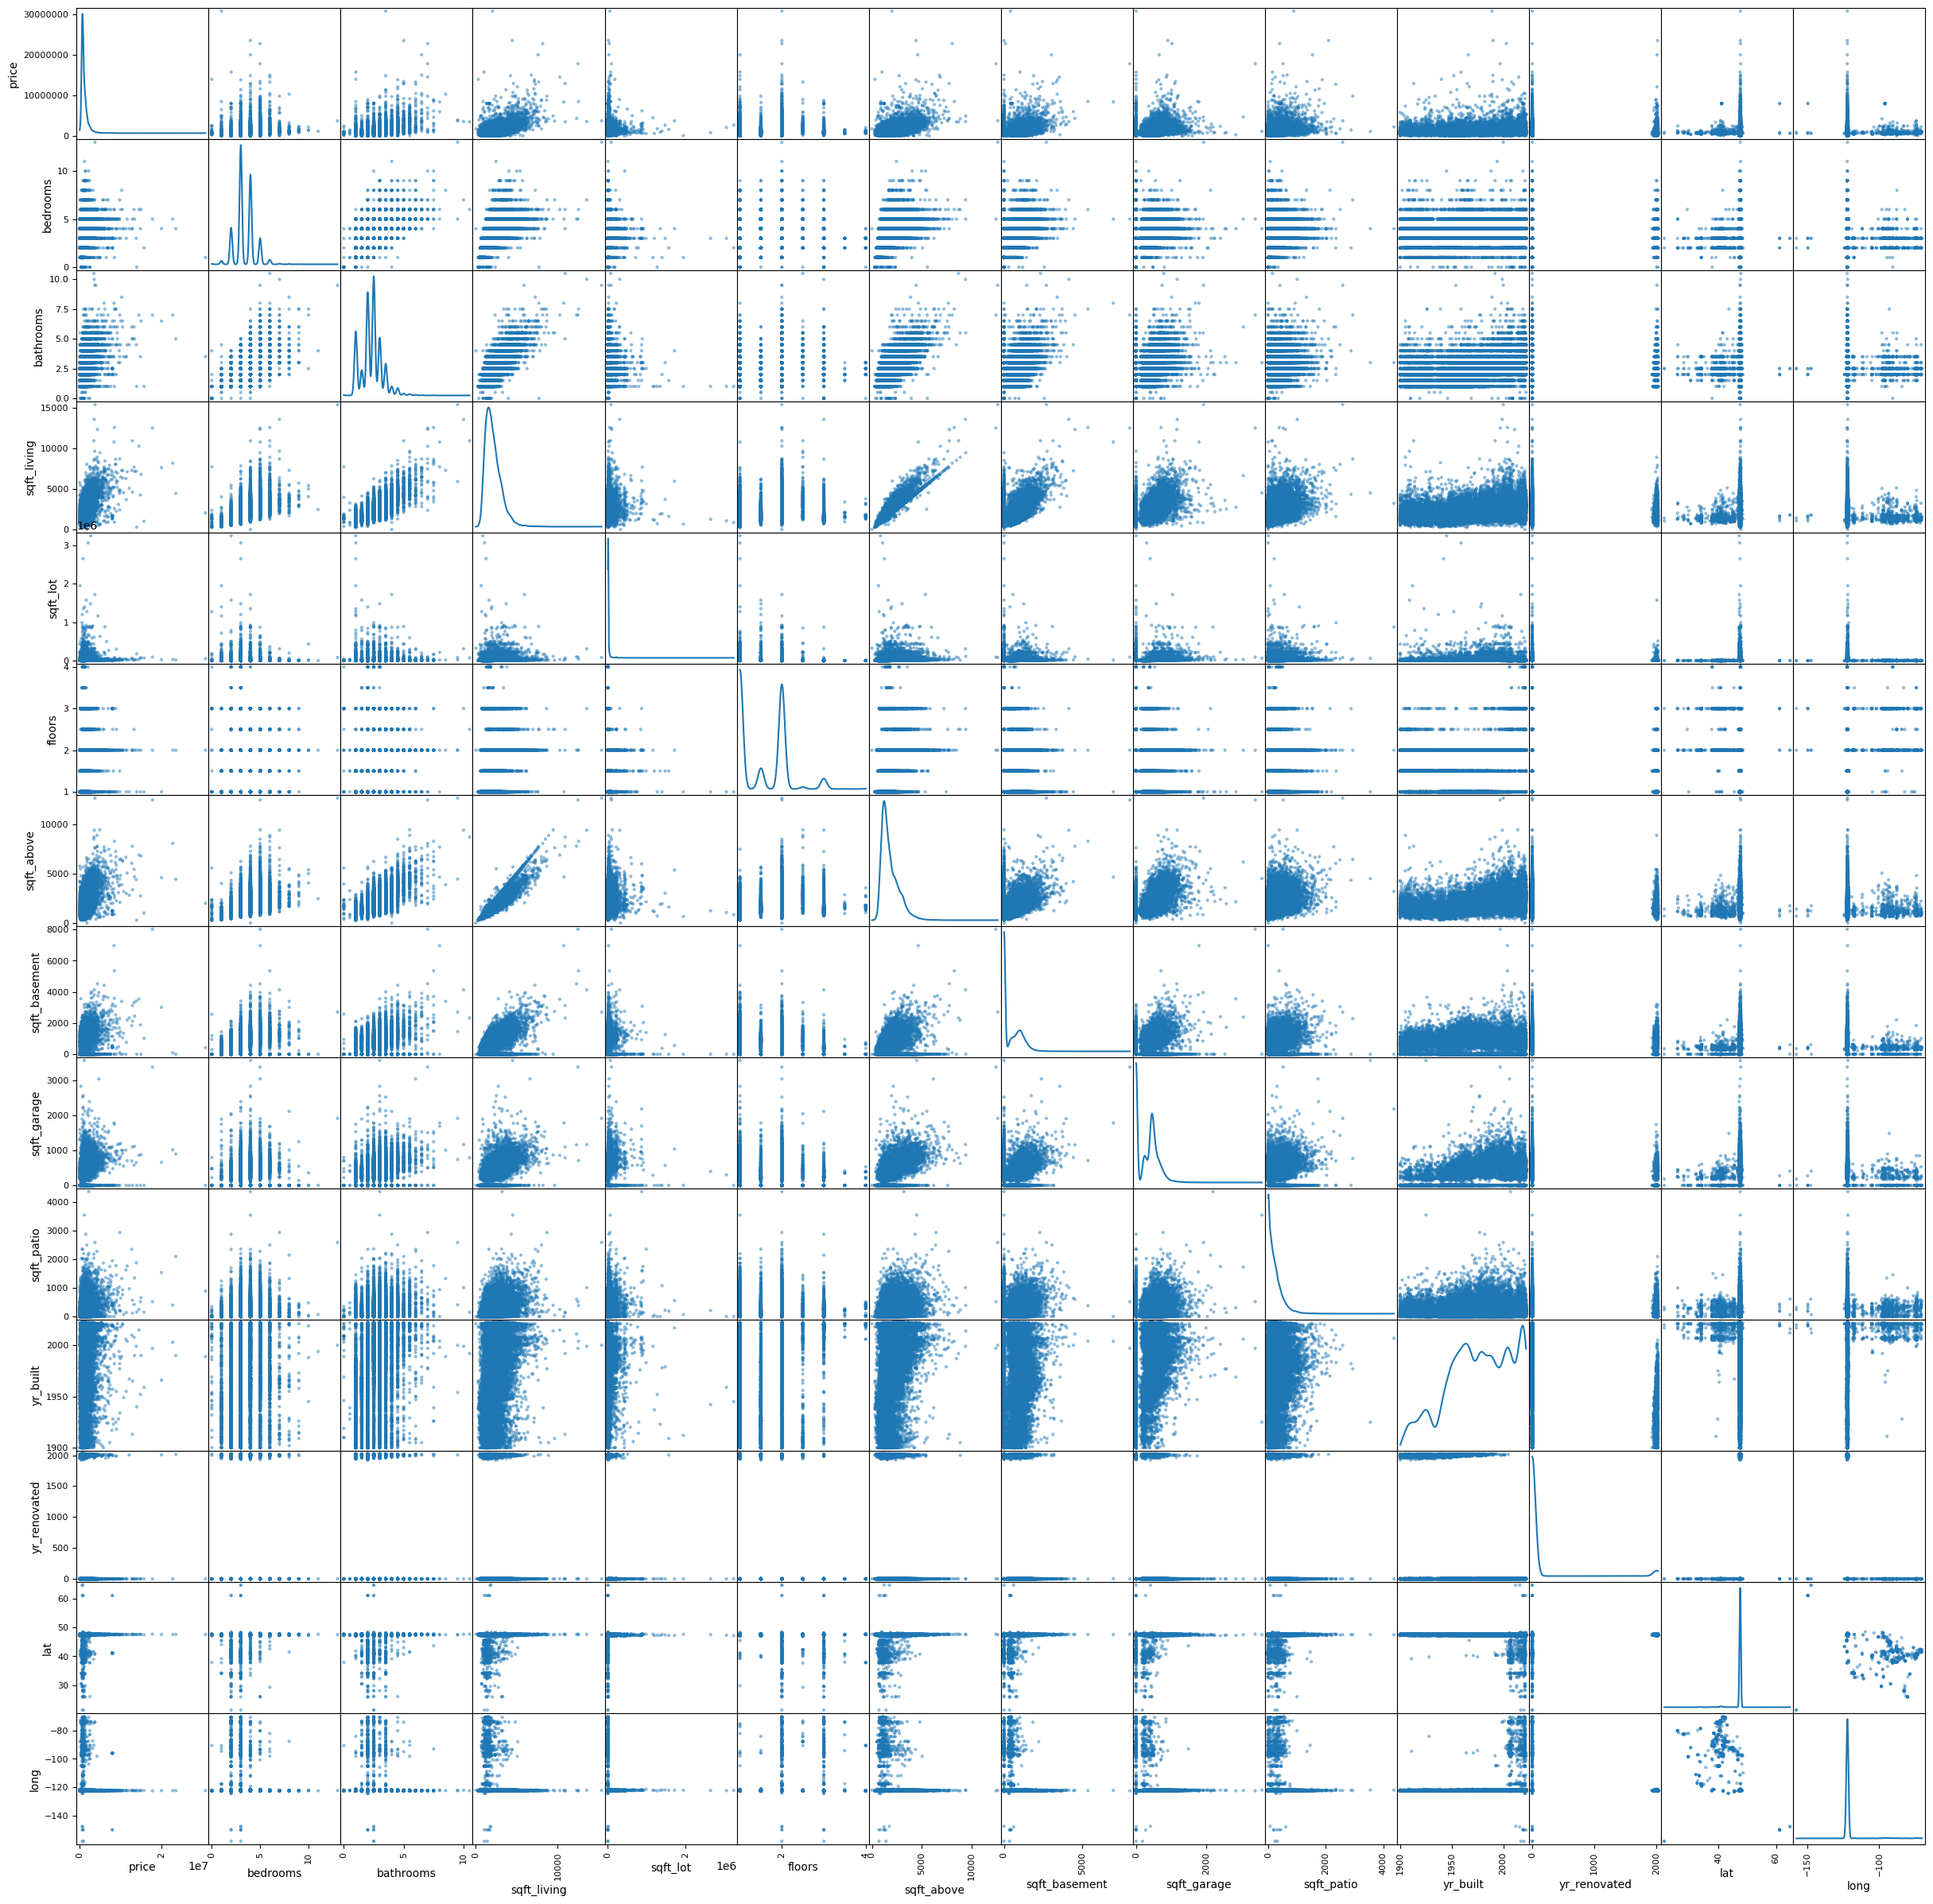

In [17]:
# Creating a scatter matrix to show the distributions of data in the DataFrame

matr = pd.plotting.scatter_matrix(kc, figsize=[30,30], diagonal='kde')

In the above scatter plot matrix, there is a lot of information provided for all of the variables in the DataFrame. Some of the graphs, like the first graph for price in the top left, shows the distribution of price in the DataFrame. In this case, we can see that there is a heavy right skew, which means there are outliers that impact price.

Other plots, like the one for sqft_living in the left column, shows the correlation between `sqft_living` and `price`, as well as the density because I specified my diagonal to be `diagonal='kde'`. Based on this matrix, I can tell that I will need to look more into `yr_built` and `yr_renovated`, because of the plotting in the matrix. The scatter plot matrix for bedrooms and bathrooms looks different as well because there are a limited number of values. 

When I am looking at density rather than distributions, (when it's more of a scatter plot instead of a line graph), I can also see if there are outliers for that variable, because if there are, they will be away from the majority of the plotting. So, for `sqft_living`, and `sqft_garage` I can tell that there will be outliers. 

In [18]:
# Formatting the DataFrame so when I run .describe, I can suppress scientific notation

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [19]:
kc.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000,30111.00000
mean,1108970.65162,3.41520,2.33571,2113.34280,16648.79908,1.54351,1810.38966,476.61712,330.47531,217.45126,1975.16230,90.79277,47.32848,-121.31887
std,896515.83011,0.97976,0.88829,973.45326,59933.02985,0.56779,877.72634,579.80536,285.72502,245.30199,32.05293,416.19763,1.43331,5.72407
min,27360.00000,0.00000,0.00000,3.00000,402.00000,1.00000,2.00000,0.00000,0.00000,0.00000,1900.00000,0.00000,21.27424,-157.79148
25%,649236.00000,3.00000,2.00000,1420.00000,4850.00000,1.00000,1180.00000,0.00000,0.00000,40.00000,1953.00000,0.00000,47.40535,-122.32608
50%,860000.00000,3.00000,2.50000,1920.00000,7477.00000,1.50000,1560.00000,0.00000,400.00000,150.00000,1977.00000,0.00000,47.55144,-122.22579
75%,1300000.00000,4.00000,3.00000,2620.00000,10568.00000,2.00000,2270.00000,940.00000,510.00000,320.00000,2003.00000,0.00000,47.66992,-122.11639
max,30750000.00000,13.00000,10.50000,15360.00000,3253932.00000,4.00000,12660.00000,8020.00000,3580.00000,4370.00000,2022.00000,2022.00000,64.82407,-70.07434


Using the `.describe` function gives me information on the standard deviation, which can tell me more about any outliers, and I can also look at the average based on the mean. I can alsoo see that `yr_renovated` has mostly all 0 values, based on the average and the maximum. I can also tell that the average year for building a house in this dataset is 1975.

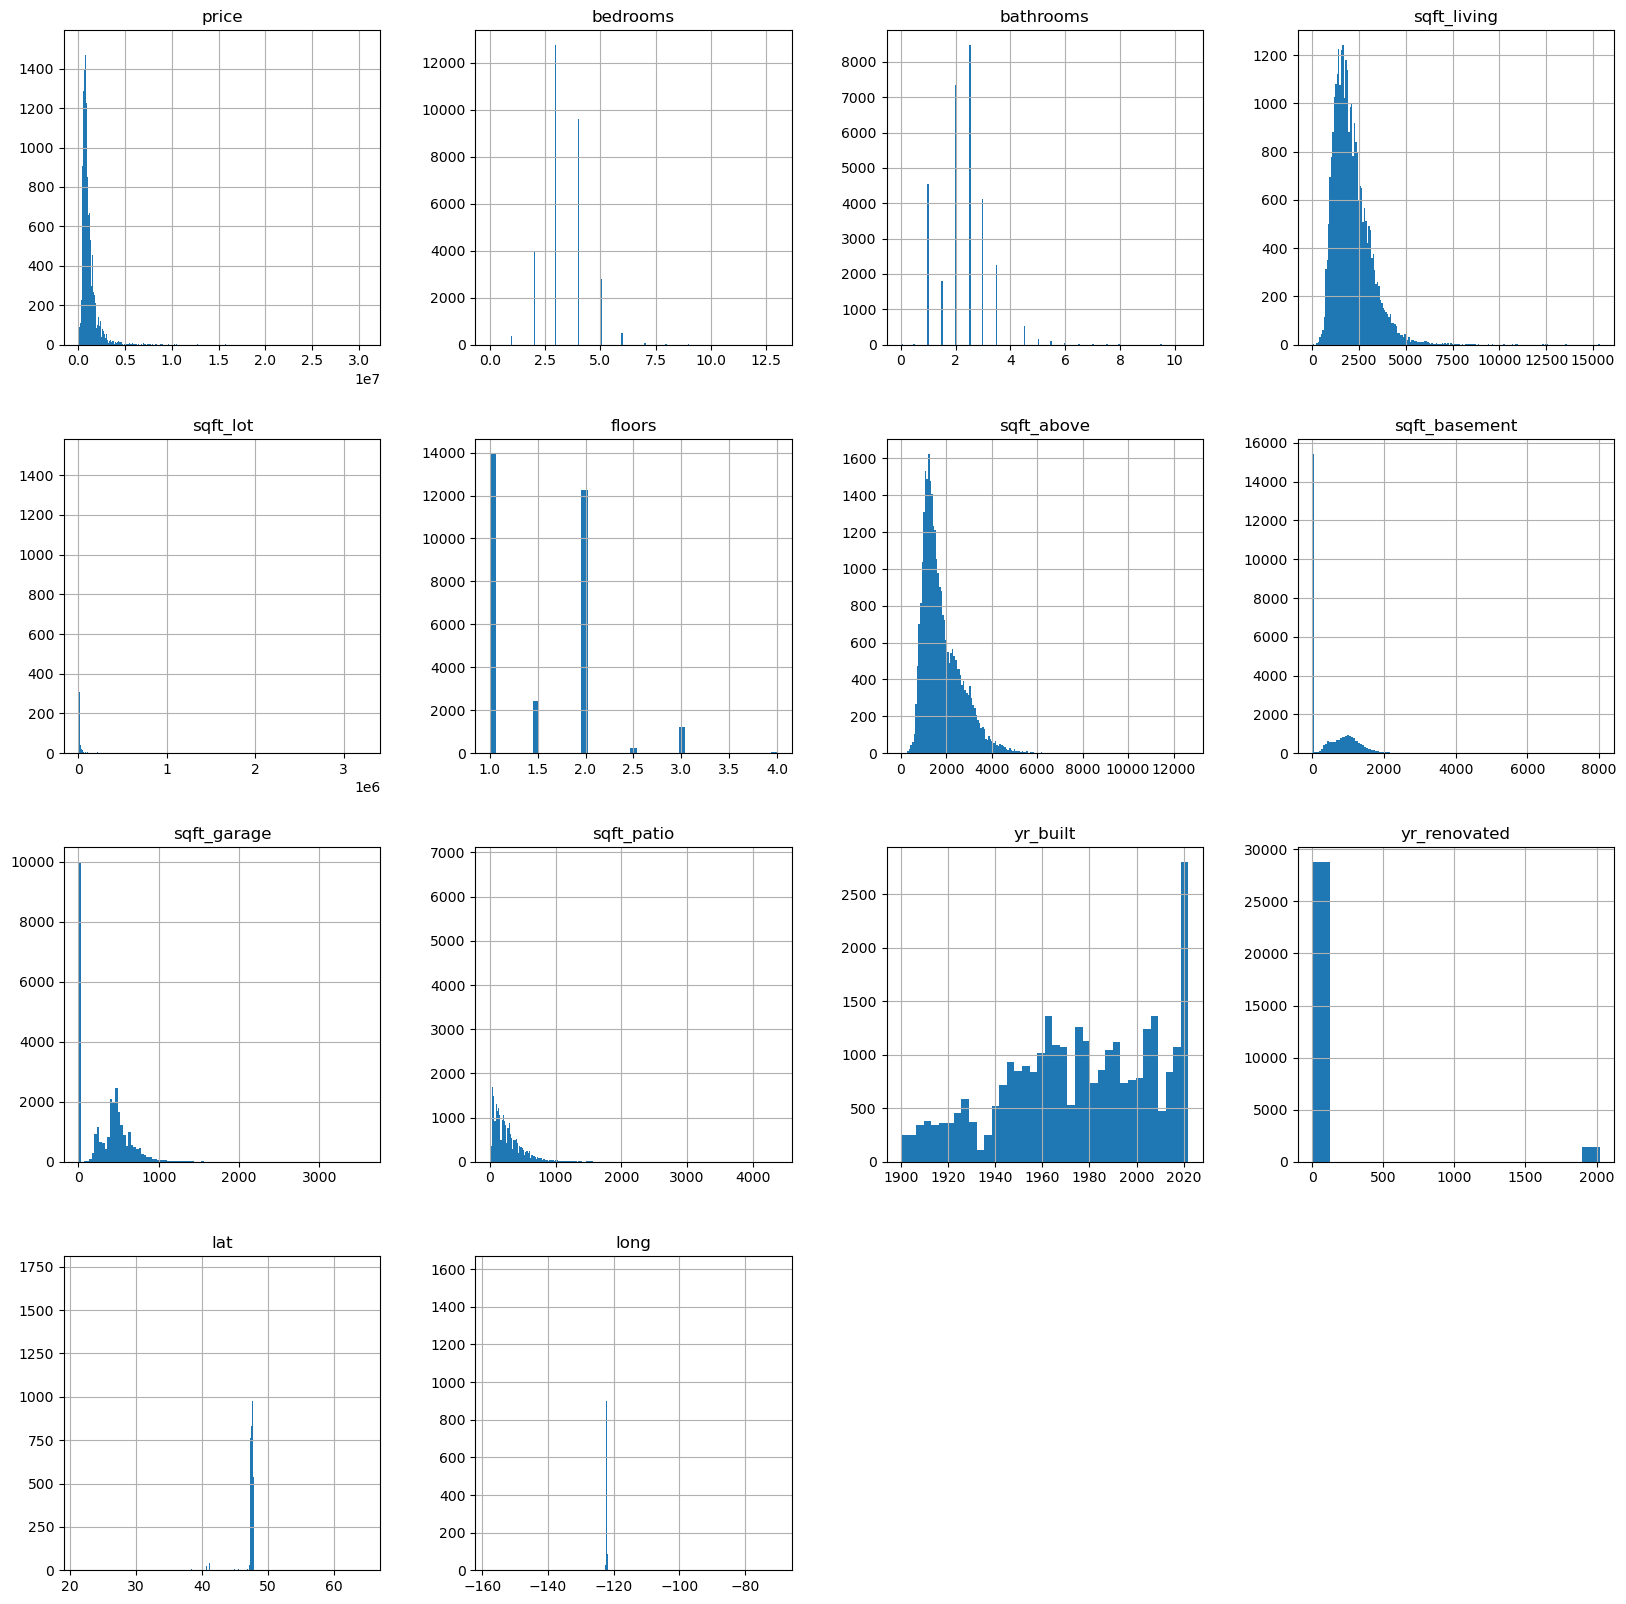

In [20]:
# Plotting histograms for the features in the DataFrame

kc.hist(bins = "auto", figsize = (20,20));

In [21]:
'''
why is my fit line of best fit on the bottom of this graph?
'''

'\nwhy is my fit line of best fit on the bottom of this graph?\n'

In [22]:
# Creating a scatter plot to show price vs sqft_living

# plot data and y = 0.1x regression line
'''
fig, ax = plt.subplots(figsize=(7, 5))
fig.suptitle('sqft_living vs. price', fontsize=16)
ax.scatter(kc['sqft_living'], kc['price'])
ax.plot(kc['sqft_living'], kc['sqft_living']/15, c='black')
ax.set_xlabel('sqft_living', fontsize=14)
ax.set_ylabel('sell price', fontsize=14);

'''

"\nfig, ax = plt.subplots(figsize=(7, 5))\nfig.suptitle('sqft_living vs. price', fontsize=16)\nax.scatter(kc['sqft_living'], kc['price'])\nax.plot(kc['sqft_living'], kc['sqft_living']/15, c='black')\nax.set_xlabel('sqft_living', fontsize=14)\nax.set_ylabel('sell price', fontsize=14);\n\n"

### Building a Baseline Simple Linear Regression Model

Building a baseline is important because it is what I will compare the model reiterations to. The goal will be to get a better R-squared, so I know that the models are getting more and more accurate, as well as the MAE. In order to create a proper baseline, the first thing I'm going to do is one-hot encode the categorical columns. Later on, I will remove outliers and remove some of the columns based on their P-value. 

#### One-Hot Encoding Categorical Variables

In [23]:
# Creating dummy variables for the object data types

kc = pd.get_dummies(kc, columns=['waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 
                                          'grade', 'heat_source', 'sewer_system'], drop_first=True)

In [24]:
# Removing the United States part from the address to get closer to the zip code

kc['address'] = kc['address'].str.replace(', United States', '')

In [25]:
# Checking to see what address looks like now

kc['address']

id
7399300360    2102 Southeast 21st Court, Renton, Washington ...
8910500230    11231 Greenwood Avenue North, Seattle, Washing...
1180000275    8504 South 113th Street, Seattle, Washington 9...
1604601802    4079 Letitia Avenue South, Seattle, Washington...
8562780790    2193 Northwest Talus Drive, Issaquah, Washingt...
                                    ...                        
7834800180    4673 Eastern Avenue North, Seattle, Washington...
194000695     4131 44th Avenue Southwest, Seattle, Washingto...
7960100080    910 Martin Luther King Jr Way, Seattle, Washin...
2781280080    17127 114th Avenue Southeast, Renton, Washingt...
9557800100     18615 7th Avenue South, Burien, Washington 98148
Name: address, Length: 30111, dtype: object

In [26]:
# Creating a variable for zipcode by taking the last five characters from address

kc['zipcode'] = kc['address'].str[-5::]

kc['zipcode']

id
7399300360    98055
8910500230    98133
1180000275    98178
1604601802    98118
8562780790    98027
              ...  
7834800180    98103
194000695     98116
7960100080    98122
2781280080    98055
9557800100    98148
Name: zipcode, Length: 30111, dtype: object

In [27]:
# Checking to see what the data looks like now with zipcode

kc.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,...,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC,sewer_system_PUBLIC RESTRICTED,zipcode
id,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.00000,4,1.00000,1180,7140,1.00000,1180,0,0,...,0,1,0,0,0,0,0,1,0,98055
8910500230,12/13/2021,920000.00000,5,2.50000,2770,6703,1.00000,1570,1570,0,...,0,0,0,1,0,0,0,1,0,98133
1180000275,9/29/2021,311000.00000,6,2.00000,2880,6156,1.00000,1580,1580,0,...,0,1,0,0,0,0,0,1,0,98178
1604601802,12/14/2021,775000.00000,3,3.00000,2160,1400,2.00000,1090,1070,200,...,0,1,0,0,0,0,0,1,0,98118
8562780790,8/24/2021,592500.00000,2,2.00000,1120,758,2.00000,1120,550,550,...,0,0,0,0,0,0,0,1,0,98027


In [28]:
# Dropping date from my DataFrame because that isn't useful for my model

kc.drop('date', axis=1, inplace=True)

In [29]:
# Checking again that all of my variables are a numerical datatype

kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30111 entries, 7399300360 to 9557800100
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            30111 non-null  float64
 1   bedrooms                         30111 non-null  int64  
 2   bathrooms                        30111 non-null  float64
 3   sqft_living                      30111 non-null  int64  
 4   sqft_lot                         30111 non-null  int64  
 5   floors                           30111 non-null  float64
 6   sqft_above                       30111 non-null  int64  
 7   sqft_basement                    30111 non-null  int64  
 8   sqft_garage                      30111 non-null  int64  
 9   sqft_patio                       30111 non-null  int64  
 10  yr_built                         30111 non-null  int64  
 11  yr_renovated                     30111 non-null  int64  
 12  addr

In [30]:
# Copying the zipcode column that I will get dummy variables for later

kc['zipcode2'] = kc.loc[:,'zipcode'] 

In [31]:
# Creating dummy variables for the object data types and dropping the first column to avoid the dummy variable trap

kc = pd.get_dummies(kc, columns=['zipcode2'], drop_first=True)

In [32]:
# Dropping original zipcode column

kc = kc.drop(['zipcode'], axis=1)

In [33]:
# Dropping address from the DataFrame because I already have zipcode

kc.drop(['address'], axis=1, inplace=True)

In [34]:
# Creating variables to perform regression analysis

y = kc["price"]
X = sm.add_constant(kc.drop(['price'], axis=1))

In [35]:
# Creating a simple linear regression

model = sm.OLS(y, sm.add_constant(X)).fit()

In [36]:
# Printing results of the model to evaluate model performance

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     143.2
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        20:39:52   Log-Likelihood:            -4.3824e+05
No. Observations:               30111   AIC:                         8.774e+05
Df Residuals:                   29668   BIC:                         8.811e+05
Df Model:                         442                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Since the *R-squared* of this model is 0.681, I know that this model is accurately predicting about 68% of house prices. However, *Adjusted R-squared* is a more accurate representation and is lower because I have so many variables in this model that might not be statistically significant enough to contribute to the model. Now, I'm going to look at what fields I should remove based on their outliers, then I will remove columns based on multicollinearity, and finally I will remove variables with high P-values. 

Before I go ahead and reiterate this model, I am going to look at the MAE and RMSE of this model so I can compare later on.

In [ ]:
'''
When dropping the first for one hot encoding, make sure to include that when evaluating the model.

ie, include the dropped columns in the model (11762 vs the column that was dropped)

interpret p values, coefficients, two recommendations from the coefficients for the stakeholder

Also might want to have interpretation
'''

#### Mean Absolute Errorr (MAE)

In [37]:
# Checking Mean Absolute Error for the first model to set a baseline

residuals = model.resid

# Print residuals 

residuals

id
7399300360    293578.26202
8910500230   -122514.28860
1180000275   -495915.20374
1604601802   -314493.33090
8562780790   -125610.23343
                  ...     
7834800180    387404.10403
194000695      81009.12528
7960100080   -208248.52106
2781280080     55943.91268
9557800100    103458.80060
Length: 30111, dtype: float64

In [38]:
# Return predicted values from model
y_pred = model.fittedvalues

# View predicted values
y_pred

id
7399300360    381421.73798
8910500230   1042514.28860
1180000275    806915.20374
1604601802   1089493.33090
8562780790    718110.23343
                  ...     
7834800180   1167595.89597
194000695    1231990.87472
7960100080   1008248.52106
2781280080    719056.08732
9557800100    396541.19940
Length: 30111, dtype: float64

In [39]:
# True y value

y = kc['price']

In [40]:
# Return mean absolute error of model
mae_resid = np.mean(np.abs(y - y_pred))

# View residuals from model
mae_resid

241389.80805098722

The MAE of a model explains the average error of the model, so in this case the model has an average error of $241,389.81 USD when predicting home prices.

#### Root Mean Squared Error

In [41]:
# Return Root Mean Squared Error
rmse_residuals = np.sqrt(model.mse_resid)

# Print Root Mean Squared Error
rmse_residuals

510282.21467349

The Root Mean Squared Error of a model explains the difference between the true value and the value the model predicts. That being said, this first iteration of the regression model has a RMSE of $510,282.21 USD. Since the RMSE > MAE of this model, it lets me know that there are outliers in my dataset which need to be removed. That is expected because it is the first iteration with all variables included.

### Identifying Outliers

Some of the features with outliers that I noticed previously in the DataFrame when I ran .describe were bedrooms and sqft_living. I'm going to look at both visually in different formats, and determine if I should in fact be removing outliers based on the number of bedrooms or the amount of square footage.

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

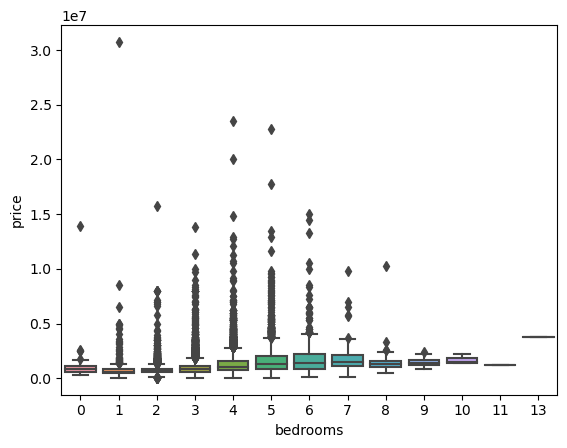

In [42]:
# Creating a boxplot to see how bedrooms impact price

sns.boxplot(x=kc['bedrooms'], y=kc['price'])

Based on this boxplot, I don't need to remove bedroom outliers, because the homes with more than 8 bedrooms actually tend to be lower in price. That might be because the bedrooms are smaller, there aren't as many bathrooms as there are bedrooms (since the maximum of bathrooms was 8), or home buyers simply aren't interested in a home with that many bedrooms. There is one home with only one bedroom that is actually highest in price, which could mean that it's in a great area or potentially the penthouse of a luxury building. 

I am going to create a density distribution plot for price so I can check if there is a skew in the dataset, and then curate a more normal distribution if needed. 

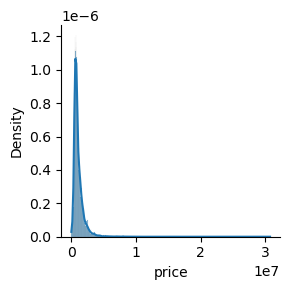

In [43]:
sns.displot(kc['price'], stat="density", height=3, kde=True)

In [44]:
# Checking the origial skew before I remove outliers

kc['price'].skew()

6.607690595812311

It's clear that the distribution plot for price has a heavy right skew, so I'm going to remove outliers based on the Interquartile Range (IQR), which means I'll remove the bottom quarter and the top quarter of the dataset. 

In [45]:
# Creating variables for q1 and q3 and creating a variable for IQR

q1 = kc['price'].quantile(0.25)
q3 = kc['price'].quantile(0.75)
IQR = q3-q1
print(IQR)

650764.0


In [46]:
# Creating variables for upper bound and lower bound, which will be the parameters for what I end up excluding

upper_bound = q3 + (1.5 * IQR)
lower_bound = q1 - (1.5 * IQR)

print(upper_bound)

print(lower_bound)

2276146.0
-326910.0


In [47]:
# Removing upper bound and lower bound from price in kc DataFrame

kc['price'] = kc.loc[kc['price'] < upper_bound, 'price']
kc['price'] = kc.loc[kc['price'] > lower_bound, 'price']

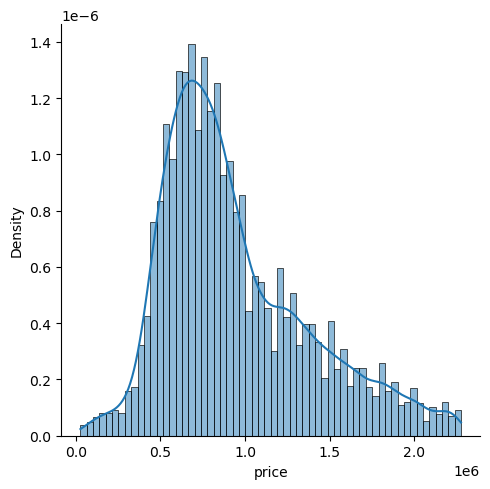

In [48]:
# Plotting the new distribution plot after removing outliers

sns.displot(kc['price'], stat="density", kde=True)

In [49]:
# Checking the skew after I've removed outliers

kc['price'].skew()

0.9043254181296857

The skew decreased from 6.6 to 0.9, and visually, price has a more normal distribution in the plot above, so I'm going to continue onto the next step.

In [50]:
kc.dropna(inplace=True)

In [53]:
kc.shape

(28120, 443)

### Reiterating the Model

Now that I've removed outliers, I'm going to create another model, and afterwards I will evaluate the coefficients and drop columns based on the P-values. 

In [54]:
# Creating variables to perform regression analysis

y = kc["price"]
X = sm.add_constant(kc.drop(['price'], axis=1))

# Creating a simple linear regression

model = sm.OLS(y, sm.add_constant(X)).fit()

# Printing results of the model to evaluate model performance

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     164.2
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        20:42:45   Log-Likelihood:            -3.8727e+05
No. Observations:               28120   AIC:                         7.754e+05
Df Residuals:                   27694   BIC:                         7.789e+05
Df Model:                         425                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

### Evaluating Regression Summary Coefficients

In this summary, the R-squared (uncentered) represents how well the algorithm is predicting price, and that is high because almost every single field is in the model. The Adj. R-squared (uncentered) is a little lower because there are so many of those predictors in the model. The F-statistic and Prob (F-statistic) should have a great difference between the two, like it does in this regression summary.

The coefficient of each independent variable is what that number would be if the price were $0. The std err is the standard deviation for the variable. If the t value associated with the t-test is equal to 0, then the null hypothesis would be accepted. If the t value is not equal to 0, then the null hypothesis can't be accepted.

To determine what I'd like to keep in my model, I'm going to also look at the P-values of the summary. Since my alpha is 0.05, any P-value would mean that I would reject the null hypothesis. Accordingly, anything greater than 0.05 would lead me to fail to reject the null hypothesis because I'm striving for a 95% confidence interval. In this summary, there are a lot of fields with P-values greater than 0.05, so I'm going to remove all of the fields that have a high P-value.

In [56]:
# Removing columns with P-values that are > 0.05

kc.drop(['grade_12 Luxury', 'grade_2 Substandard', 'grade_3 Poor', 'heat_source_Electricity/Solar', 'heat_source_Oil',
        'heat_source_Oil/Solar', 'heat_source_Other', 'sewer_system_PUBLIC RESTRICTED', 'zipcode2_02066', 
         'zipcode2_02134', 'zipcode2_02149', 'zipcode2_07006', 'zipcode2_07031', 'zipcode2_07063', 'zipcode2_07079', 
         'zipcode2_07087', 'zipcode2_07103', 'zipcode2_07107', 'zipcode2_07111', 'zipcode2_07504', 'zipcode2_07513', 
         'zipcode2_07650', 'zipcode2_07712', 'zipcode2_08054', 'zipcode2_08096', 'zipcode2_08360', 'zipcode2_08520', 
         'zipcode2_08752', 'zipcode2_10011', 'zipcode2_10550', 'zipcode2_11105', 'zipcode2_11204', 'zipcode2_11360', 
         'zipcode2_11363', 'zipcode2_11369', 'zipcode2_11370', 'zipcode2_11373', 'zipcode2_11501', 'zipcode2_11703',
         'zipcode2_11717','zipcode2_11731', 'zipcode2_11772', 'zipcode2_11980', 'zipcode2_12546', 'zipcode2_15120',
         'zipcode2_15301', 'zipcode2_16601', 'zipcode2_17111', 'zipcode2_17922', 'zipcode2_18960', 'zipcode2_19104',
         'zipcode2_19129', 'zipcode2_19139', 'zipcode2_19146', 'zipcode2_21702', 'zipcode2_25177', 'zipcode2_33179',
         'zipcode2_45044','zipcode2_45659', 'zipcode2_47060', 'zipcode2_47265', 'zipcode2_47272', 'zipcode2_47546',
        'zipcode2_47575', 'zipcode2_47714', 'zipcode2_50161', 'zipcode2_50237', 'zipcode2_55734', 'zipcode2_56387', 
        'zipcode2_58018', 'zipcode2_58042', 'zipcode2_58212', 'zipcode2_58490', 'zipcode2_62204', 'zipcode2_62205',
        'zipcode2_62859', 'zipcode2_62896', 'zipcode2_63601', 'zipcode2_63624', 'zipcode2_63640', 'zipcode2_63653',
        'zipcode2_67801', 'zipcode2_70584', 'zipcode2_72751', 'zipcode2_73064', 'zipcode2_73118', 'zipcode2_75050',
        'zipcode2_76205', 'zipcode2_78216', 'zipcode2_78257', 'zipcode2_79339', 'zipcode2_79423', 'zipcode2_85040',
        'zipcode2_85207', 'zipcode2_85210', 'zipcode2_85295', 'zipcode2_85705', 'zipcode2_91910', 'zipcode2_92250'],
        axis=1, inplace=True)

In [58]:
# Seeing how many less columns there are in the DataFrame

kc.shape

(28120, 344)

#### Reiterating the model Again

In [59]:
# Creating variables to perform regression analysis

y = kc["price"]
X = sm.add_constant(kc.drop(['price'], axis=1))

# Creating a simple linear regression

model = sm.OLS(y, sm.add_constant(X)).fit()

# Printing results of the model to evaluate model performance

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     204.7
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        23:30:57   Log-Likelihood:            -3.8736e+05
No. Observations:               28120   AIC:                         7.754e+05
Df Residuals:                   27780   BIC:                         7.782e+05
Df Model:                         339                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Removing the P-values from the previous model decreased the R-squared slightly, but it also slightly lessened the difference between the R-squared and Adjusted R-squared. Now, I will continue removing features based on the P-values of the model's summary.

In [61]:
# Dropping more of the columns that have a P-value > 0.05

kc.drop(['zipcode2_02568', 'zipcode2_02645', 'zipcode2_02790', 'zipcode2_02852', 'zipcode2_02916', 'zipcode2_07719',
        'zipcode2_08260', 'zipcode2_11215', 'zipcode2_11704', 'zipcode2_11762', 'zipcode2_13205', 'zipcode2_15010',
        'zipcode2_15064', 'zipcode2_15223', 'zipcode2_16001', 'zipcode2_17702', 'zipcode2_29405', 'zipcode2_29582',
        'zipcode2_33054', 'zipcode2_34116', 'zipcode2_34208', 'zipcode2_34470', 'zipcode2_43210', 'zipcode2_43211',
        'zipcode2_44714', 'zipcode2_45039', 'zipcode2_45403', 'zipcode2_45856', 'zipcode2_46032', 'zipcode2_46151',
        'zipcode2_46554', 'zipcode2_46929', 'zipcode2_47805', 'zipcode2_48336', 'zipcode2_48503', 'zipcode2_49090',
        'zipcode2_49783', 'zipcode2_49858', 'zipcode2_50325', 'zipcode2_50644', 'zipcode2_52040', 'zipcode2_52172',
        'zipcode2_52241', 'zipcode2_52405', 'zipcode2_52590', 'zipcode2_52732', 'zipcode2_53081', 'zipcode2_53213', 
        'zipcode2_54007', 'zipcode2_54736', 'zipcode2_54751', 'zipcode2_55021', 'zipcode2_55063', 'zipcode2_55112',
        'zipcode2_55117', 'zipcode2_55356', 'zipcode2_55379', 'zipcode2_55407', 'zipcode2_55411', 'zipcode2_55412',
        'zipcode2_55929', 'zipcode2_56303', 'zipcode2_58059', 'zipcode2_58102', 'zipcode2_58104', 'zipcode2_58203',
        'zipcode2_58801', 'zipcode2_59102', 'zipcode2_60155', 'zipcode2_61104', 'zipcode2_61108', 'zipcode2_61201',
        'zipcode2_61244', 'zipcode2_61264', 'zipcode2_61933', 'zipcode2_62281', 'zipcode2_62401', 'zipcode2_62703',
        'zipcode2_63014', 'zipcode2_63090', 'zipcode2_63301', 'zipcode2_64116', 'zipcode2_64119', 'zipcode2_64156',
        'zipcode2_64503', 'zipcode2_64641', 'zipcode2_65049', 'zipcode2_66102', 'zipcode2_66104', 'zipcode2_67846',
        'zipcode2_68031', 'zipcode2_68106', 'zipcode2_68132', 'zipcode2_68307', 'zipcode2_68347', 'zipcode2_68354',
        'zipcode2_68455', 'zipcode2_68502', 'zipcode2_68504', 'zipcode2_68632', 'zipcode2_68643', 'zipcode2_68652',
        'zipcode2_68660', 'zipcode2_68788', 'zipcode2_68862', 'zipcode2_68972', 'zipcode2_69154', 'zipcode2_80210',
        'zipcode2_80401', 'zipcode2_80904', 'zipcode2_83712', 'zipcode2_84104', 'zipcode2_84115', 'zipcode2_84790',
        'zipcode2_85296', 'zipcode2_89108', 'zipcode2_90063', 'zipcode2_90605', 'zipcode2_92879', 'zipcode2_93033', 
        'zipcode2_93041', 'zipcode2_94122', 'zipcode2_94403', 'zipcode2_94530', 'zipcode2_94607', 'zipcode2_95205', 
        'zipcode2_95240', 'zipcode2_96816', 'zipcode2_97006', 'zipcode2_98004', 'zipcode2_98005', 'zipcode2_98033',
        'zipcode2_98039', 'zipcode2_98040', 'zipcode2_98052', 'zipcode2_98075', 'zipcode2_98109', 'zipcode2_98223',
        'zipcode2_98270', 'zipcode2_99202', 'zipcode2_99223'], axis=1, inplace=True)

In [62]:
# Creating variables to perform regression analysis

y = kc["price"]
X = sm.add_constant(kc.drop(['price'], axis=1))

# Creating a simple linear regression

model = sm.OLS(y, sm.add_constant(X)).fit()

# Printing results of the model to evaluate model performance

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     340.3
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        00:08:43   Log-Likelihood:            -3.8760e+05
No. Observations:               28120   AIC:                         7.756e+05
Df Residuals:                   27919   BIC:                         7.773e+05
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

The R-squared of the model decreased again, but again there is less difference between the R-squared and Adjusted R-squared, which means that the model is less likely to be overfit. However, there are more features that will need to be removed based on high P-values which won't be statistically significant.

In [64]:
kc.drop(['zipcode2_08204', 'zipcode2_11510', 'zipcode2_18052', 'zipcode2_33619', 'zipcode2_34601', 'zipcode2_54002',
        'zipcode2_55382', 'zipcode2_55406', 'zipcode2_56472', 'zipcode2_56537', 'zipcode2_56560', 'zipcode2_59405',
        'zipcode2_64124', 'zipcode2_66109', 'zipcode2_66503', 'zipcode2_68133', 'zipcode2_68628', 'zipcode2_68651',
        'zipcode2_68826', 'zipcode2_68970', 'zipcode2_80238', 'zipcode2_83687', 'zipcode2_87507', 'zipcode2_91343',
        'zipcode2_93523', 'zipcode2_95822', 'zipcode2_97210', 'zipcode2_97459', 'zipcode2_98372', 'zipcode2_98387',
        'zipcode2_99203', 'zipcode2_99403'], axis=1, inplace=True)

In [65]:
# Creating variables to perform regression analysis

y = kc["price"]
X = sm.add_constant(kc.drop(['price'], axis=1))

# Creating a simple linear regression

model = sm.OLS(y, sm.add_constant(X)).fit()

# Printing results of the model to evaluate model performance

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     399.3
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        00:29:37   Log-Likelihood:            -3.8764e+05
No. Observations:               28120   AIC:                         7.756e+05
Df Residuals:                   27949   BIC:                         7.770e+05
Df Model:                         170                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In the above model, the R-squared is .708, and the Adjusted R-squared is 0.707. However, all of the P-values of the columns are statistically significant. Now, I'm going to do one more iteration of the model where I remove some of the columns that are multicollinear. To look at multicollinearity, I'm going to use the .stack method again on this dataframe.

In [66]:
# Utilzing .stack to get returned a list that will return multicollinear relationships

multi = kc.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns
multi['pairs'] = list(zip(multi.level_0, multi.level_1))

# set index to new pairs column
multi.set_index(['pairs'], inplace = True)

#drop level columns that were created originally by default
multi.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column
multi.columns = ['cc']

# drop duplicates in case any were created in this process
multi.drop_duplicates(inplace=True)

Now I know which pairs have a high multicollinearity, so I'm going to drop `sqft_above` because it is already accounted for in `sqft_living`. I'm also going to drop `lat` and `long` because I didn't use the coordinates of 
homes, but rather the zip codes in this model. I will keep `bathrooms` because it is a variable that homeowners and real estate investment firms should recognize as important in renovations or when purchasing a home.

In [68]:
# Running below code to return the pairs that have a greater correlation than .75 and less than 1

multi[(multi.cc>.75) & (multi.cc <1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.85594
"(long, lat)",0.75666


In [69]:
# Since sqft_living includes sqft_above, I'm going to drop sqft_above from the model as well

kc.drop(['sqft_above'], axis=1, inplace=True)

I'm also going to drop the yr_renovated column, because it isn't an accurate representation since most homes have a value of 0.

In [72]:
# Dropping yr_renoveated from the DataFrame

kc.drop(['yr_renovated'], axis=1, inplace=True)

### Final Iteration of the Model

In [73]:
# Creating variables to perform regression analysis

y = kc["price"]
X = sm.add_constant(kc.drop(['price'], axis=1))

# Creating a simple linear regression

model = sm.OLS(y, sm.add_constant(X)).fit()

# Printing results of the model to evaluate model performance

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     397.9
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        00:47:34   Log-Likelihood:            -3.8779e+05
No. Observations:               28120   AIC:                         7.759e+05
Df Residuals:                   27951   BIC:                         7.773e+05
Df Model:                         168                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

#### Mean Absolute Error (MAE)

In [74]:
# Checking Mean Absolute Error for the first model to set a baseline

residuals = model.resid

# Print residuals 

residuals

id
7399300360    186843.63184
8910500230    -71897.16387
1180000275   -572413.80680
1604601802   -336677.85273
8562780790   -130351.99718
                  ...     
7834800180    381129.26444
194000695     218450.06530
7960100080    -36054.83363
2781280080      6744.77524
9557800100     20404.81424
Length: 28120, dtype: float64

In [75]:
# Return predicted values from model
y_pred = model.fittedvalues

# View predicted values
y_pred

id
7399300360    488156.36816
8910500230    991897.16387
1180000275    883413.80680
1604601802   1111677.85273
8562780790    722851.99718
                  ...     
7834800180   1173870.73556
194000695    1094549.93470
7960100080    836054.83363
2781280080    768255.22476
9557800100    479595.18576
Length: 28120, dtype: float64

In [76]:
# True y value

y = kc['price']

In [77]:
# Return mean absolute error of model
mae_resid = np.mean(np.abs(y - y_pred))

# View residuals from model
mae_resid

165811.5589294044

The MAE of a model explains the average error of the model, so in this case the model has an average error of $$165,811,56, which is $$75,578.25 less than the original MAE of $241,389.81 USD when predicting home prices.

#### Root Mean Squared Error

In [78]:
# Return Root Mean Squared Error
rmse_residuals = np.sqrt(model.mse_resid)

# Print Root Mean Squared Error
rmse_residuals

236752.9211272136

The Root Mean Squared Error of a model explains the difference between the true value and the value the model predicts. The new RMSE of 236,752.92 USD which is 53.6 percent less than the original RMSE of 510,282.21 USD. Still, the RMSE > MAE of this model as well, so if I were to continue iterating through this model I could look for more outliers. 

### Evaluating the Final Model and Deriving Recommendations

In [ ]:
'''
The coefficient of a feature may be interpreted differently based on the column that was dropped, (Morgan sent article)
May still need to include interpretation of linear regression assumption
-Reintroduce heatmap in exploratory data section, explore correlations
-Homoscedactity, normality (distribution), linearity (scatter plot)
'''